# Autoencoder

### What is an autoencoder?

<img src="https://www.bing.com/cr?IG=885EC41BE539497C9EE824A5C9504706&CID=0240B4B5EAD465A51D4DBE3CEB3364BE&rd=1&h=f0zkfH3BPFYkjMpArARfnf-D_m4PAuX2BDl1MtQCxAY&v=1&r=https%3a%2f%2fi.stack.imgur.com%2fZwsmz.png&p=DevEx,5049.1">

An autoencoder is an artificial neural network which is able to learn efficients rappresentations of the input data in an unsupervised manner.

Typically, these representations (called *codings*) have a lower dimensionality than the input, making this type of NN useful for PCA (see my notebook on dimensionality reduction).

Furthermore, if trained they are able to generate new data that are similar to the input, becoming **generative models**.

## PCA with Autoencoders: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from sklearn.preprocessing import StandardScaler

# Generate some random 3D points
rnd.seed(42)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m)/2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m)/2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [9]:
import tensorflow as tf

n_inputs = 3
n_hidden = 2 # internal representation (codings)
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # Mean Squared Error

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [10]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

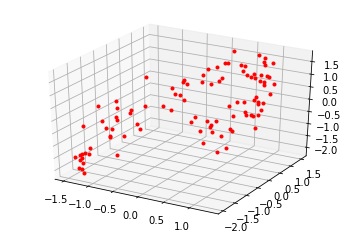

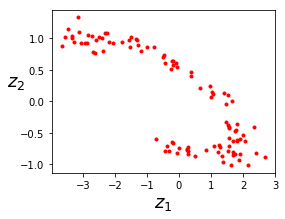

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# 3D version
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_train[:, 0], X_train[:, 1], X_train[:, 2], "r.")
plt.show()

# 2D version
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "r.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked Autoencoders

Just like other NNs, we can stack multiple hidden layers to create a **deep autoencoder**.
In this way it will recognize more complex patterns in the input data, but **be careful**:

*don't make the autoencoder too deep, or it will perfectly copy the input, without learning anything about it.*

<img src="https://images.ecosia.org/ZfhEYYoII0n8tKwNskjhbBg6oXM=/0x390/smart/https%3A%2F%2Fwww.bing.com%2Fcr%3FIG%3D885EC41BE539497C9EE824A5C9504706%26CID%3D0240B4B5EAD465A51D4DBE3CEB3364BE%26rd%3D1%26h%3DaTXFDwhk5T5LlcwtjvOT5POl47DwOLyHYyIa5B9BwO0%26v%3D1%26r%3Dhttps%253a%252f%252fassets.toptal.io%252fuploads%252fblog%252fimage%252f335%252ftoptal-blog-image-1395721542588.png%26p%3DDevEx%2C5031.1">

In [27]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [29]:
# Download MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [31]:
'''Expecially in very deep autoencoders, training one autoencoder at a time performs better. You can train them in one single
graph or, like here, in multiple graphs.'''

reset_graph()

from functools import partial
import sys

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [32]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.0183982
19% Train MSE: 0.0177385
29% Train MSE: 0.0196133
3 Train MSE: 0.0193563
09% Train MSE: 0.00431181
1 Train MSE: 0.00469678
2 Train MSE: 0.00464812
39% Train MSE: 0.00441583


In [33]:
'''Now we can stack the previous trained autoencoders and compute the result.'''
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

In [45]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.show()

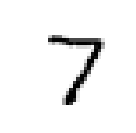

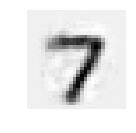

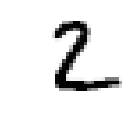

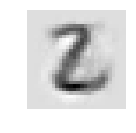

In [47]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    outputs_val = outputs.eval(feed_dict={X: X_test})

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## References
1) [Hands-On Machine Learning](http://shop.oreilly.com/product/0636920052289.do)<br>
2) [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

I highly recommend the book in the first link to learn much more about autoencoders and all ML/DL related stuff.